# Service Push Message Effect Analysis
## 概要

サービスAを対象に、アプリのログインを促すために6/10~6/16の1週間、一部のユーザーに対してプッシュメッセージを送る施策を行いました。

メッセージタイプには"A"と"B"の2種類があり、それぞれ受け取るユーザー群が異なります。メッセージのプッシュ回数については1回のユーザー群と2回のユーザー群があります。プッシュメッセージの効果として同期間(6/10 ~ 6/16)のログイン回数が通常より増えたことが認められれば、この施策を全ユーザーに展開しようと計画しています。

施策効果を比較するためにプッシュメッセージを配信してないユーザー群を対照群としたとき、今回の施策効果について分析を行ってください。

In [37]:
import random
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.set(font='Yu Gothic')
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["font.size"] = 22
plt.rcParams["figure.dpi"] = 80

warnings.filterwarnings('ignore')

In [38]:
root = './datasets'
exp_design_path = f'{root}/experimental_design.csv'
user_login_path = f'{root}/user_login.csv'

# Vizulization Experimental Design

In [39]:
exp_df = pd.read_csv(exp_design_path)
print('experimental_design.csv has {} rows; {} columns'.format(*exp_df.shape))

experimental_design.csv has 11595 rows; 3 columns


In [40]:
exp_df.nunique()

user_id     11595
push_cnt        3
msg_type        3
dtype: int64

#### Let's look up the sample size of each message type and push count.  
まずメッセージタイプとプッシュ回数のサンプルサイズを見ましょう。

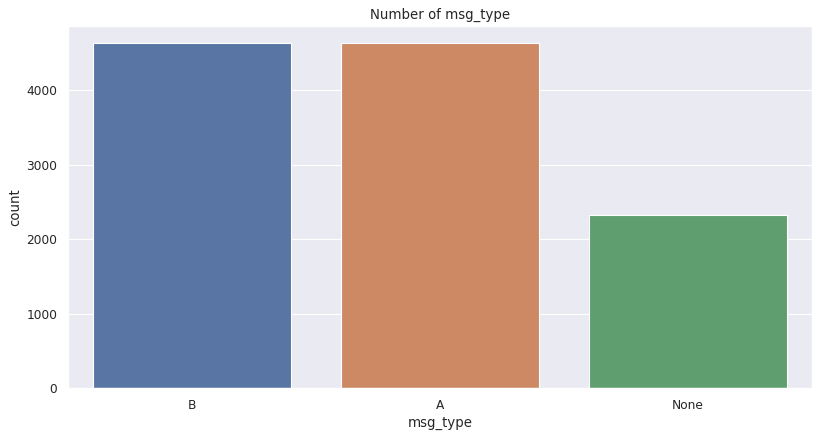

In [41]:
sns.countplot(exp_df['msg_type'])
plt.title('Number of msg_type')
plt.show()

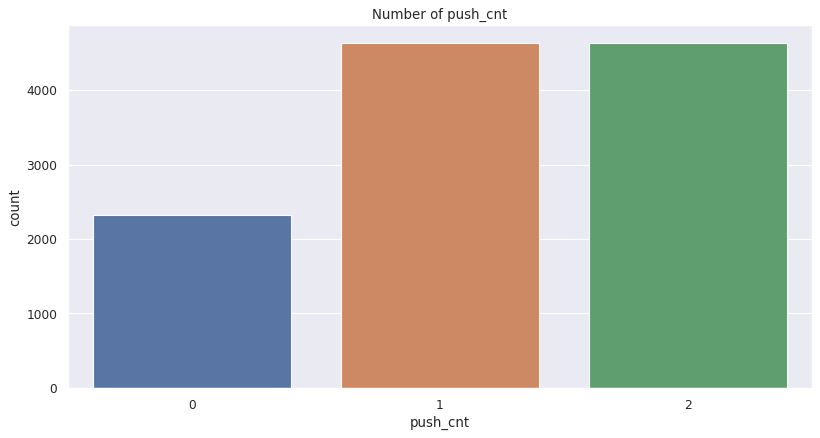

In [42]:
sns.countplot(exp_df['push_cnt'])
plt.title('Number of push_cnt')
plt.show()

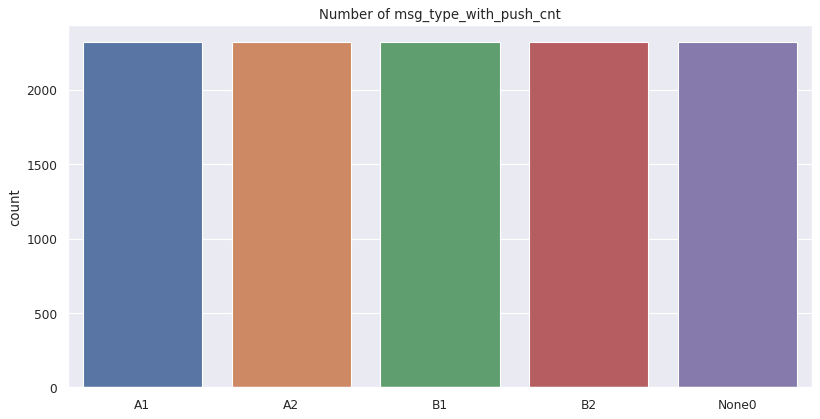

In [43]:
msg_type_with_push_cnt = (exp_df['msg_type'] + exp_df['push_cnt'].astype(str)).sort_values()
sns.countplot(msg_type_with_push_cnt)
plt.title('Number of msg_type_with_push_cnt')
plt.show()

In [44]:
pd.pivot_table(exp_df, columns='push_cnt', index='msg_type', aggfunc='count')

user_id                
push_cnt       0       1       2
msg_type                        
A            NaN  2319.0  2319.0
B            NaN  2319.0  2319.0
None      2319.0     NaN     NaN

Each push message type with push count have exactly **same number of user_id**  
メッセージタイプとプッシュ回数の組み合わせしたそれぞれの受け取るユーザー群の人数は全部同じ

In [45]:
exp_df.isna().sum().sum()
print('There are no missing data in exp_df')

There are no missing data in exp_df


# Handle User Login

In [46]:
login_df = pd.read_csv(user_login_path)
print('user_login.csv has {} rows; {} columns'.format(*login_df.shape))

user_login.csv has 649466 rows; 2 columns


In [47]:
login_df.isna().sum()

user_id      0
timestamp    0
dtype: int64

In [48]:
login_df['timestamp'] = pd.to_datetime(login_df['timestamp'])
login_df['day'] = login_df['timestamp'].dt.day
login_df['dayofweek'] = login_df['timestamp'].dt.dayofweek

## 1. Data Cleaning(データのクリーニング)
* Remove `user_id` which not includeed in experimental_design
* Drop duplicate login record (`user_id` with exactly same `timestamp`)  


* experimental_design に含まれない `user_id` を削除する。
* 重複するログインレコードを削除する  

In [49]:
# Remove unseen user_id
exp_user_id = exp_df['user_id'].unique()
unseen_user_id = login_df.query('user_id not in @ exp_user_id')
n_unseen_user_id = unseen_user_id['user_id'].nunique()
print(f'user_login has {n_unseen_user_id} user_id not included in the experimental_design')

user_login has 1160 user_id not included in the experimental_design


In [50]:
new_login_df = (login_df
                .query('user_id in @ exp_user_id')
                .reset_index(drop=True))

In [51]:
# Drop duplicate record
duplicate_login = new_login_df[new_login_df.duplicated()]
new_login_df.drop_duplicates(inplace=True)
print(f'Drop {len(duplicate_login)} duplicate user_id login recorded at exactly same time')

Drop 16 duplicate user_id login recorded at exactly same time


In [52]:
print('new_login_df has {} rows; {} columns'.format(*new_login_df.shape))

new_login_df has 617449 rows; 4 columns


In [53]:
new_login_df.nunique()

user_id       11595
timestamp    483750
day              14
dayofweek         7
dtype: int64

<AxesSubplot:>

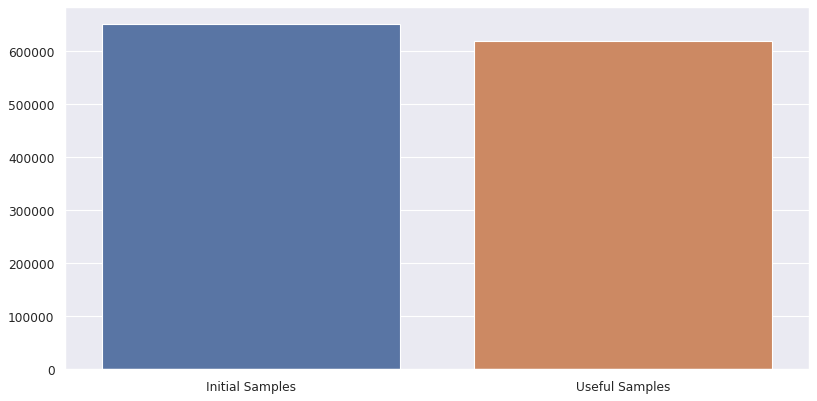

In [54]:
sns.barplot(x=['Initial Samples', 'Useful Samples'], y=[len(login_df), len(new_login_df)])

In [55]:
new_login_df['week2'] = new_login_df.timestamp >= '2019-06-10'

In [56]:
new_login_df.sample(5)

,user_id,timestamp,day,dayofweek,week2
331937,u00007476,2019-06-10 18:00:44+00:00,10,0,True
89955,u00002546,2019-06-05 02:41:11+00:00,5,2,False
208538,u00001161,2019-06-07 21:39:04+00:00,7,4,False
459664,u00005308,2019-06-13 13:01:57+00:00,13,3,True
519881,u00009095,2019-06-14 20:49:15+00:00,14,4,True


## 3. Vizualization

In [57]:
login_count_by_day = (new_login_df
                      .groupby(['day', 'user_id'])
                      .agg({'timestamp': 'count'})
                      .unstack(0)
                      .droplevel(level=0, axis=1)
                      .fillna(0)
                     )
login_count_by_day = pd.merge(login_count_by_day, exp_df, on='user_id')

In [58]:
avg_login_count_by_day = login_count_by_day.groupby(['msg_type', 'push_cnt']).agg('mean')

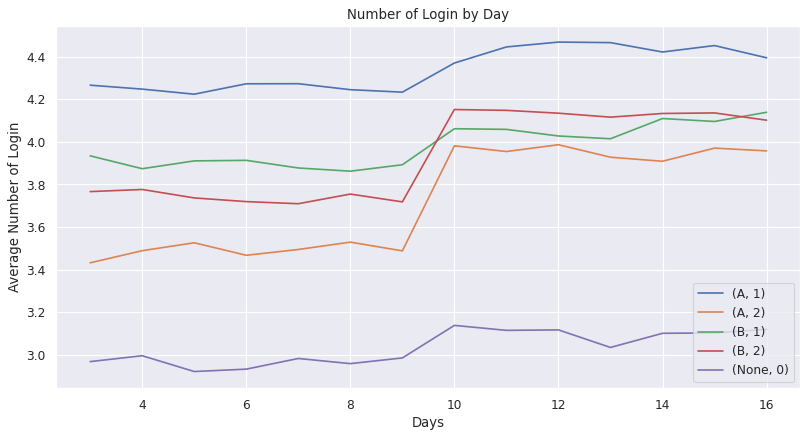

In [59]:
avg_login_count_by_day.T.plot()
plt.title('Number of Login by Day')
plt.xlabel('Days')
plt.ylabel('Average Number of Login')
plt.legend(loc='lower right')
plt.show()

It looks like each group has more logins in the second week than first week  
各グループとも、1週目より2週目の方がログイン数が多いようです。

#### Vizulization Number of Login Change

In [60]:
login_count = (new_login_df
               .groupby(['week2', 'user_id'])
               .agg({'timestamp': 'count'})
               .unstack(0)
               .droplevel(level=0, axis=1))

login_count.columns = ['n_login_week1', 'n_login_week2']
login_count['change'] = login_count['n_login_week2'] - login_count['n_login_week1']

# Merge expermental design
login_count = pd.merge(login_count, exp_df, on='user_id')

In [61]:
login_count.head()

,user_id,n_login_week1,n_login_week2,change,push_cnt,msg_type
0,u00000001,30,33,3,2,B
1,u00000002,29,32,3,2,B
2,u00000003,24,27,3,2,A
3,u00000004,25,27,2,0,None
4,u00000005,24,27,3,2,B


In [26]:
login_count.describe()

,n_login_week1,n_login_week2,change,push_cnt
count,11595.000000,11595.000000,11595.000000,11595.000000
mean,25.677965,27.573351,1.895386,1.200000
std,3.979847,4.166891,1.098249,0.748364
min,18.000000,18.000000,0.000000,0.000000
25%,22.000000,26.000000,1.000000,1.000000
50%,26.000000,27.000000,2.000000,1.000000
75%,29.000000,31.000000,3.000000,2.000000
max,33.000000,34.000000,4.000000,2.000000


In [27]:
group_login_count = login_count.groupby(['msg_type', 'push_cnt']).agg('mean')
group_login_count.round(2)

n_login_week1  n_login_week2  change
msg_type push_cnt                                      
A        1                 29.76          31.02    1.26
         2                 24.43          27.69    3.26
B        1                 27.27          28.51    1.24
         2                 26.18          28.92    2.74
None     0                 20.75          21.73    0.98

Average number of logins increased compared to last week  
先週に比べ、平均ログイン回数の増加
* msg_type `A` with push `1` times, `+1.26`
* msg_type `A` with push `2` times, `+3.26`
* msg_type `B` with push `1` times, `+1.24`
* msg_type `B` with push `2` times, `+2.74`
* msg_type `None`, `+0.98`

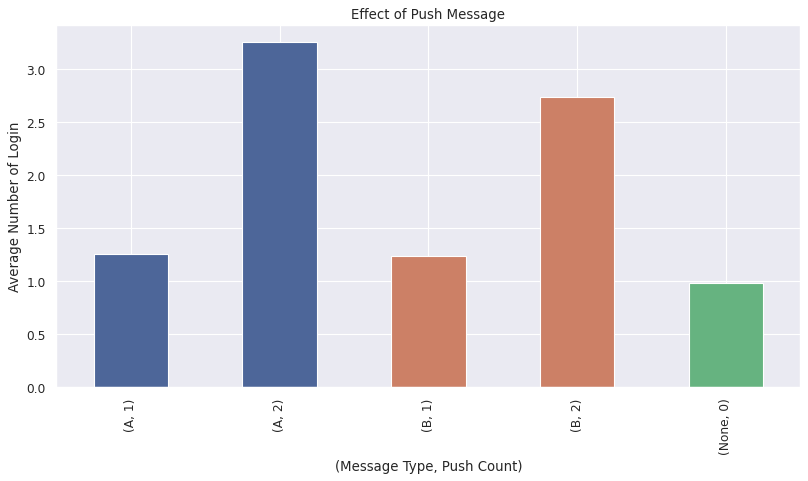

In [28]:
blue = (0.3, 0.4, 0.6)
orange = (0.8, 0.5, 0.4)
green = (0.4, 0.7, 0.5)
group_login_count['change'].plot(kind='bar', color=[blue, blue, orange, orange, green])
plt.title('Effect of Push Message')
plt.xlabel('(Message Type, Push Count)')
plt.ylabel('Average Number of Login')
plt.show()

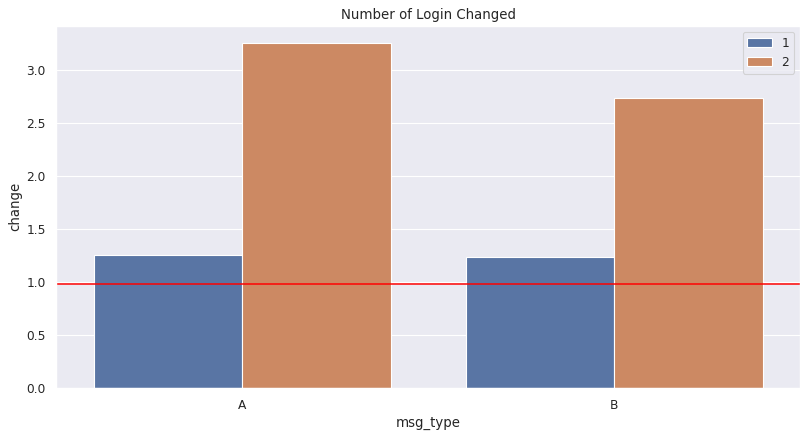

In [29]:
group_login_count.reset_index(inplace=True)
sns.barplot(data=group_login_count[group_login_count.msg_type != 'None'],
            y='change',
            x='msg_type',
            hue='push_cnt')
plt.title('Number of Login Changed')
plt.legend(loc="upper right")
plt.axhline(group_login_count.at[4, 'change'], color='red', alpha=0.9)
plt.show()

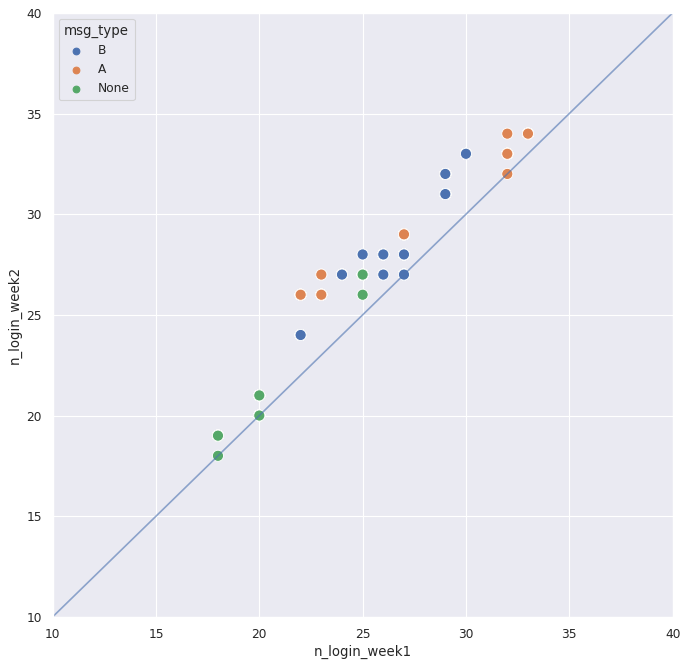

In [30]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=login_count, x='n_login_week1', y='n_login_week2', hue='msg_type', s=100)
plt.xlim(10, 40)
plt.ylim(10, 40)
plt.axline((10, 10), (40, 40), alpha=0.6)
plt.show()

# Hypothesis testing（統計的仮説検定）

In [31]:
import scipy.stats as st

In [32]:
groups = {}
for msg_type in ['None', 'A', 'B']:
    if msg_type == 'None':
        df = login_count.query("msg_type==@msg_type")
        groups['None_0'] = df
    else:
        for push_cnt in [1, 2]:
            df = login_count.query("msg_type==@msg_type and push_cnt==@push_cnt")
            groups[f'{msg_type}_{push_cnt}'] = df

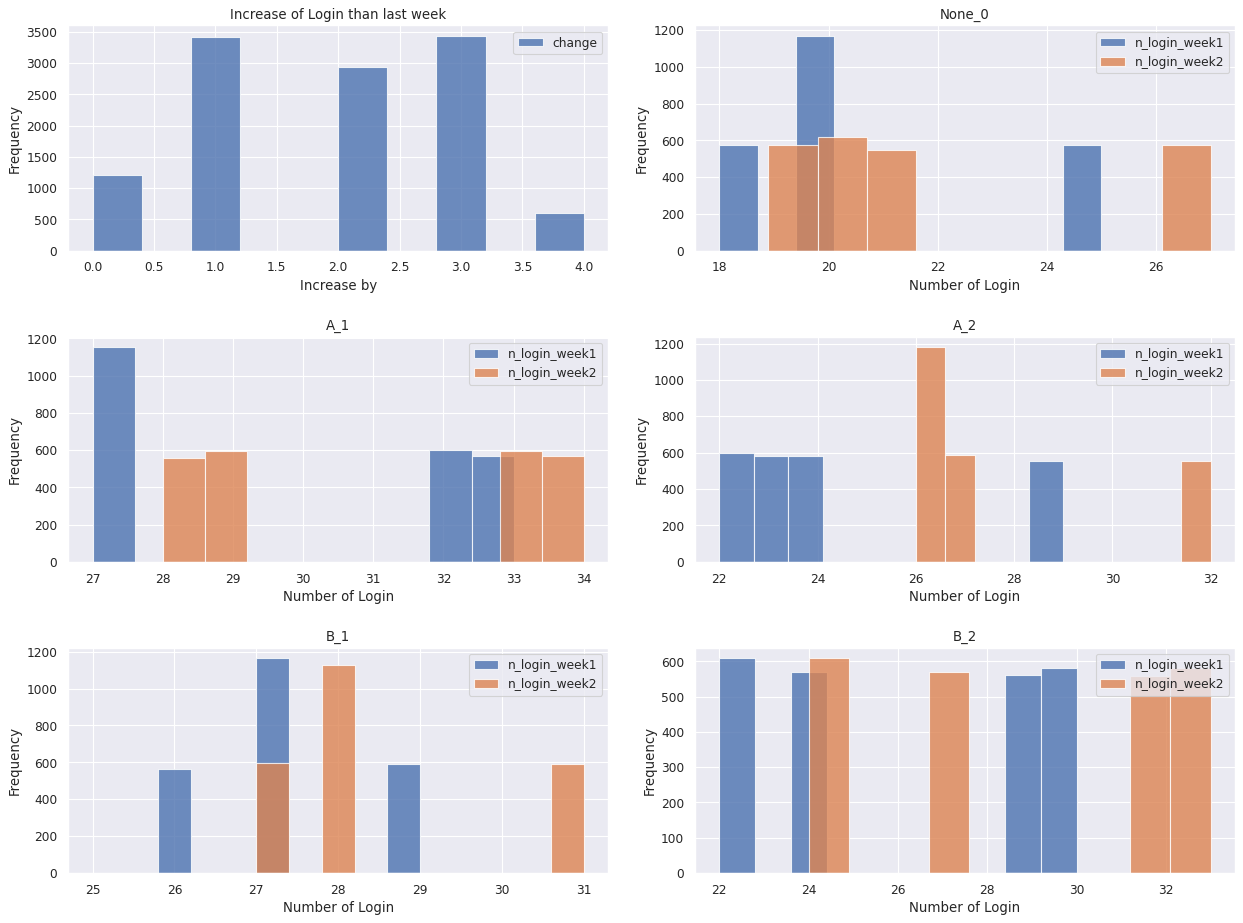

In [33]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
login_count.change.plot(kind='hist', bins=10, alpha=0.8, ax=ax[0][0])
ax[0][0].set_xlabel('Increase by')
ax[0][0].set_title('Increase of Login than last week')
ax[0][0].legend()

for idx, (name, df) in enumerate(groups.items()):
    axs = ax[(idx+1)//2][(idx+1)%2]
    df.n_login_week1.plot(kind='hist', bins=10, alpha=0.8, ax=axs)
    df.n_login_week2.plot(kind='hist', bins=10, alpha=0.8, ax=axs)
    axs.set_title(name)
    axs.set_xlabel('Number of Login')
    axs.legend()
plt.tight_layout()
plt.show()

## 1. Shapiro-Wilk normality test（シャピロ–ウィルク検定）

The Shapiro-Wilk test examines if a variable is normally distributed in a population.  
シャピロ–ウィルク検定とは、 統計学において、標本が正規分布に従う母集団からサンプリングされたものであるという帰無仮説を検定する検定である。
[source](https://ja.wikipedia.org/wiki/%E3%82%B7%E3%83%A3%E3%83%94%E3%83%AD%E2%80%93%E3%82%A6%E3%82%A3%E3%83%AB%E3%82%AF%E6%A4%9C%E5%AE%9A)

In [34]:
for name, df in groups.items():
    print("\nType: {}, Count: {}".format(*name.split('_')))
    for week in ['n_login_week1', 'n_login_week2', 'change']:
        p_value = st.shapiro(df[week])[1]
        if p_value > 0.05:
            msg = 'its normal distribution'
        else:
            msg = 'not normal distribution'
        print("  {}: P-value={}, {}".format(week, p_value, msg))


Type: None, Count: 0
  n_login_week1: P-value=0.0, not normal distribution
  n_login_week2: P-value=0.0, not normal distribution
  change: P-value=0.0, not normal distribution

Type: A, Count: 1
  n_login_week1: P-value=0.0, not normal distribution
  n_login_week2: P-value=0.0, not normal distribution
  change: P-value=0.0, not normal distribution

Type: A, Count: 2
  n_login_week1: P-value=0.0, not normal distribution
  n_login_week2: P-value=0.0, not normal distribution
  change: P-value=0.0, not normal distribution

Type: B, Count: 1
  n_login_week1: P-value=0.0, not normal distribution
  n_login_week2: P-value=0.0, not normal distribution
  change: P-value=0.0, not normal distribution

Type: B, Count: 2
  n_login_week1: P-value=0.0, not normal distribution
  n_login_week2: P-value=0.0, not normal distribution
  change: P-value=0.0, not normal distribution


### The Conclusions of Hypothesis Testing
  None of these data are **normal distribution**, We will use **Nonparametric tests**.  
  Now, we need to operationalize two test here: 
* Wilcoxon Signed Rank Test  
* Wilcoxon Rank Sum Test

### 仮説検定の結論
  これらのデータはいずれも**正規分布**ではないので、**ノンパラメトリック検定**を用いることにします。 
  ここで2つの検定手法を運用する必要があります。
* ウィルコクソンの符号順位検定 
* ウィルコクソンの順位和検定

## 2. Wilcoxon Signed Rank Test（ウィルコクソンの符号順位検）

The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.  
ウィルコクソンの符号順位検定は一対の標本によるノンパラメトリック検定法である。
[source](https://ja.wikipedia.org/wiki/%E3%82%A6%E3%82%A3%E3%83%AB%E3%82%B3%E3%82%AF%E3%82%BD%E3%83%B3%E3%81%AE%E7%AC%A6%E5%8F%B7%E9%A0%86%E4%BD%8D%E6%A4%9C%E5%AE%9A)

Test if second week has more logins than first week in the same user group.  
同一グループ内でプッシュメッセージを受信した後にログイン回数が増加するかどうかを検定する。
* `h0`:  eta <= eta0
* `h1`:  eta > eta0

In [35]:
for name, group in groups.items():
    wsrt = st.wilcoxon(group['n_login_week2'], group['n_login_week1'], alternative='greater')
    print("Type: {}, Count: {}".format(*name.split('_')))
    if wsrt[1] < 0.05:
        result = """-Reject null hypothesis, alternative hypothesis is true.
-Push message could increase number of login in group {}
""".format(name)
    else:
        result = """Couldn't reject null hypothesis.
The data do not indicate a difference with or without push message.
"""
    print(result)

Type: None, Count: 0
-Reject null hypothesis, alternative hypothesis is true.
-Push message could increase number of login in group None_0

Type: A, Count: 1
-Reject null hypothesis, alternative hypothesis is true.
-Push message could increase number of login in group A_1

Type: A, Count: 2
-Reject null hypothesis, alternative hypothesis is true.
-Push message could increase number of login in group A_2

Type: B, Count: 1
-Reject null hypothesis, alternative hypothesis is true.
-Push message could increase number of login in group B_1

Type: B, Count: 2
-Reject null hypothesis, alternative hypothesis is true.
-Push message could increase number of login in group B_2



### The Conclusions of Hypothesis Testing
We **reject the null hypothesis** at the 5% significance level.  
There is sufficient evidence to support the claim that in same group **push message increase more logins than normally.**

### 仮説検定の結論
5%の有意水準で帰無仮説を棄却する。 
同じグループ内では、通常よりもプッシュメッセージによるログインが増加するという主張を支持する十分な証拠がある。

## 3. Wilcoxon Rank Sum Test（ウィルコクソンの順位和検定）


The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution. The alternative hypothesis is that values in one sample are more likely to be larger than the values in the other sample.  
ウィルコクソンの順位和検定は一対の標本によるノンパラメトリック検定法である。対応のあるt検定で必要とされる仮定が満たされない場合に用いである。
[source](https://ja.wikipedia.org/wiki/%E3%82%A6%E3%82%A3%E3%83%AB%E3%82%B3%E3%82%AF%E3%82%BD%E3%83%B3%E3%81%AE%E7%AC%A6%E5%8F%B7%E9%A0%86%E4%BD%8D%E6%A4%9C%E5%AE%9A)
  
Test if user group who **received the message** increased their logins more than those who did **not receive the message**.  
メッセージを受け取ったユーザーグループが、メッセージを受け取らなかったユーザーグループよりもログイン回数を増やしたかどうかを検定する。

* `h0`:  eta <= eta0
* `h1`:  eta > eta0

In [36]:
for name, group in groups.items():
    if name == 'None_0':
        continue
    wsrt = st.ranksums(group['change'], groups['None_0']['change'], alternative='greater')
    print("Type: {}, Count: {}".format(*name.split('_')))
    if wsrt[1] < 0.05:
        result = """-Reject null hypothesis, alternative hypothesis is true.
-There is sufficient evidence to support the claim push message could increase number of login.
"""
    else:
        result = """Couldn't reject null hypothesis.
The data do not indicate a difference with or without push message.
"""
    print(result)

Type: A, Count: 1
-Reject null hypothesis, alternative hypothesis is true.
-There is sufficient evidence to support the claim push message could increase number of login.

Type: A, Count: 2
-Reject null hypothesis, alternative hypothesis is true.
-There is sufficient evidence to support the claim push message could increase number of login.

Type: B, Count: 1
-Reject null hypothesis, alternative hypothesis is true.
-There is sufficient evidence to support the claim push message could increase number of login.

Type: B, Count: 2
-Reject null hypothesis, alternative hypothesis is true.
-There is sufficient evidence to support the claim push message could increase number of login.



### The Conclusions of Hypothesis Testing
We **reject the null hypothesis** at the 5% significance level in all pusu message group.  
There is sufficient evidence to support the claim that **Send a message can increase the number of logins.**

### 仮説検定の結論
5%の有意水準で帰無仮説を棄却する。 
メッセージを送ることでログイン数が増加するという主張を支持する十分な証拠がある。

# Conclusion

We reject the null hypothesis at the 5% significance level in both Wilcoxon Signed Rank Test and Wilcoxon Rank Sum Test.  
Therefore, we believe that push messaging has a significant effect on increasing the number of user logins.  
  
ウィルコクソンの符号順位検定とウィルコクソンの順位和検定のいずれにおいても、5%の有意水準で帰無仮説を棄却しています。  
したがって、プッシュメッセージはユーザーログイン数の増加に対して有意な効果があると考えられる。